# Predicting Boston House Prices

This notebook shows example of regression with TensorFlow.

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append('..')
from datasets import boston_housing

print(tf.__version__)

1.10.1


# The Data

In [2]:
(train_data, train_labels), (test_data, test_labels) = boston_housing.load()

print("Training data: {}".format(train_data.shape))
print("Test data: {}".format(test_data.shape))

Training data: (404, 13)
Test data: (102, 13)


The dataset contains 13 different features:

1. Per capita crime rate.
1. The proportion of residential land zoned for lots over 25,000 square feet.
1. The proportion of non-retail business acres per town.
1. Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
1. Nitric oxides concentration (parts per 10 million).
1. The average number of rooms per dwelling.
1. The proportion of owner-occupied units built before 1940.
1. Weighted distances to five Boston employment centers.
1. Index of accessibility to radial highways.
1. Full-value property-tax rate per $10,000.
1. Pupil-teacher ratio by town.
1. 1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town.
1. Percentage lower status of the population.

They are not in the same units & range.

In [3]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
                'TAX', 'PTRATIO', 'B', 'LSTAT']

df = pd.DataFrame(train_data, columns=column_names)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,1.23247,0.0,8.14,0.0,0.538,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72
1,0.02177,82.5,2.03,0.0,0.415,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11
2,4.89822,0.0,18.10,0.0,0.631,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26
3,0.03961,0.0,5.19,0.0,0.515,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01
4,3.69311,0.0,18.10,0.0,0.713,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65


Labels are prices in thousand dollars.

## Build the model

The model consists of fully-connected layers (`Dense`) with the last output as just a single number, the price.

In [4]:
model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(train_data.shape[1],)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1)
])

We compile the model using *mean squared error* as the loss function, using RMSProp optimizer and Mean Absolute Error as the metrics.

In [5]:
model.compile(
    loss='mse',
    optimizer=tf.train.RMSPropOptimizer(0.001),
    metrics=['mae']
)

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                896       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


## Normalize the data

This is really important. Otherwise the machine will not learn.

**Do not normalize using the test data !!**

In [7]:
mean = train_data.mean(axis = 0)
std = train_data.std(axis = 0)

# normalize both train & test data
norm_train_data = (train_data - mean) / std
norm_test_data = (test_data - mean) / std


## Train the model

Let's train the model with 500 epochs and save the training and validation accuracy history.

In [8]:
class PrintMe(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print("Epoch {} lapsed.".format(epoch))
            
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
            
history = model.fit(norm_train_data, train_labels,
                   epochs=500, validation_split=0.2, verbose=0, 
                   callbacks=[early_stop, PrintMe()])

Epoch 0 lapsed.


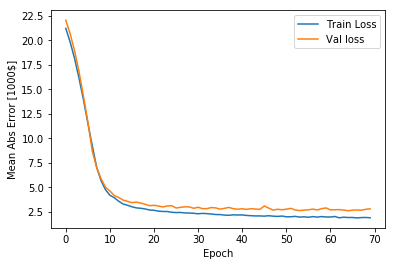

In [9]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error [1000$]')
plt.plot(history.epoch, np.array(history.history['mean_absolute_error']), 
         label='Train Loss')
plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
plt.legend()

Using early stopping function

The performance of this model on the test data.

In [10]:
[loss, mae] = model.evaluate(norm_test_data, test_labels, verbose=0)

print("Testing set mean absolute error is ${:7.2f}".format(mae * 1000))

Testing set mean absolute error is $2995.53


## Prediction

We are going to do the regression on the test data.

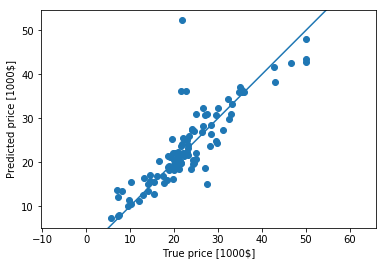

In [11]:
test_predictions = model.predict(norm_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True price [1000$]')
plt.ylabel('Predicted price [1000$]')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.plot([-100, 100], [-100, 100])

We can also show the histogram of the prediction errors.

Text(0,0.5,'Count')

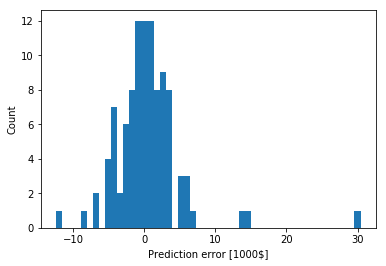

In [12]:
error = test_predictions - test_labels
plt.hist(error, bins = 50)
plt.xlabel("Prediction error [1000$]")
plt.ylabel("Count")